<a href="https://colab.research.google.com/github/LeylaY1996/sentiment-analysis-aws-reviews/blob/main/05122024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Veri setini yükle
csv_file_path = '/content/Reviews-2.csv'  # Dosya yolunuza göre güncelleyin
df = pd.read_csv(csv_file_path, on_bad_lines='skip', quoting=3, low_memory=False)  # daha yeni versiyonlar için
# Veri setinin boyutunu yazdır
print("Orijinal veri seti boyutu:", df.shape)

# %50 oranında rastgele bir alt küme seç
sampled_df = df.sample(frac=0.5, random_state=42)  # random_state ile tekrarlanabilirlik sağlar

# Yeni veri setinin boyutunu yazdır
print("Yeni veri seti boyutu:", sampled_df.shape)

# İstediğiniz gibi veriyi kaydedin veya kullanın
sampled_df.to_csv('sampled_reviews.csv', index=False)  # Yeni dosyayı kaydet

Orijinal veri seti boyutu: (149388, 10)
Yeni veri seti boyutu: (74694, 10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


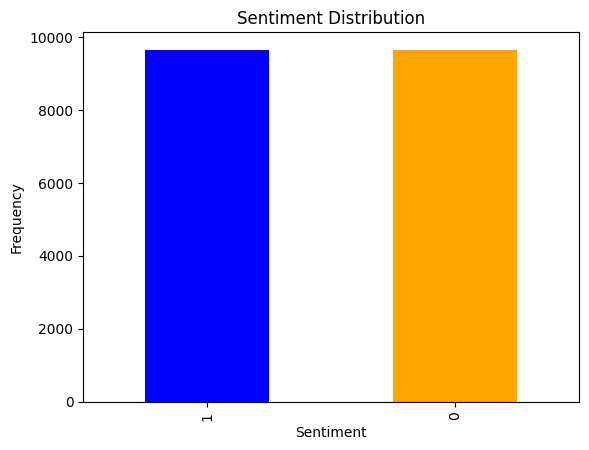

Ortalama Yorum Uzunluğu: 139.1112781175495
Standart Sapma: 88.35745446652008
Aykırı değerler çıkarıldıktan sonra veri seti boyutu: (18957, 2)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from scipy import stats

# NLTK stopwords yükle
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

def clean_text(text):
    """Metni temizler: küçük harfe çevirir, noktalama işaretlerini kaldırır ve durak kelimeleri filtreler."""
    text = text.lower()  # Küçük harfe çevir
    text = ''.join([char for char in text if char not in punctuation])  # Noktalama işaretlerini kaldır
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Durak kelimeleri filtrele
    return text

def prepare_data(csv_file):
    """Veri setini hazırlar: yükler, temizler ve etiketler."""

    # Veri setini yükle
    df = pd.read_csv(csv_file)

    # Gerekli sütunları seçin
    df = df[['Text', 'Score']]

    # 3 değerine sahip satırları çıkarın
    df = df[df['Score'] != 3]

    # Skorları ikili hale getirin (örneğin: 1-2 olumsuz, 4-5 olumlu)
    df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

    # Yorumları temizle
    df['cleaned_review'] = df['Text'].apply(clean_text)

    # Sadece temizlenmiş yorumlar ve duygu etiketlerini içeren DataFrame döndür
    return df[['cleaned_review', 'Sentiment']]

# Veriyi yükle ve hazırla
csv_file_path = '/content/sampled_reviews.csv'  # Dosya yolunuza göre güncelleyin
prepared_data = prepare_data(csv_file_path)

# Veri dengesini sağlama
# Olumlu ve olumsuz örneklerin sayısını bul
positive_samples = prepared_data[prepared_data['Sentiment'] == 1]
negative_samples = prepared_data[prepared_data['Sentiment'] == 0]

# Minimum sayıda olan sınıfa göre dengeleme
min_samples = min(len(positive_samples), len(negative_samples))
balanced_data = pd.concat([positive_samples.sample(min_samples, random_state=42),
                           negative_samples.sample(min_samples, random_state=42)])

# Histogram çizme
balanced_data['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

# Ortalama ve standart sapma hesaplama
mean_length = balanced_data['cleaned_review'].apply(len).mean()
std_length = balanced_data['cleaned_review'].apply(len).std()
print(f"Ortalama Yorum Uzunluğu: {mean_length}")
print(f"Standart Sapma: {std_length}")

# Aykırı değer kontrolü (örneğin, yorum uzunluğuna göre aykırı değer)
z_scores = np.abs(stats.zscore(balanced_data['cleaned_review'].apply(len)))
balanced_data = balanced_data[(z_scores < 3)]

print("Aykırı değerler çıkarıldıktan sonra veri seti boyutu:", balanced_data.shape)

In [3]:
# Confusion Matrix'i görselleştir
def plot_confusion_matrix(cm):
    """Confusion matrix'i görselleştirir."""
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(cm, cmap='Blues', alpha=0.6)
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_text(train_text, test_text, max_features=10000, ngram_range=(1, 2)):
    """
    Metinleri TF-IDF ile vektörize eder.
    """
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_train_tfidf = vectorizer.fit_transform(train_text)
    X_test_tfidf = vectorizer.transform(test_text)
    return X_train_tfidf, X_test_tfidf, vectorizer

In [5]:
from sklearn.model_selection import train_test_split

def split_data(df, feature_column, target_column, test_size=0.2, random_state=42):
    """
    Veri çerçevesini eğitim ve test setine böler.

    Args:
    - df: Veri çerçevesi (pandas DataFrame).
    - feature_column: Özellik sütunu adı (ör. metin verisi).
    - target_column: Hedef sütunu adı (etiketler).
    - test_size: Test setinin boyutu (varsayılan: 0.2).
    - random_state: Rastgele durum kontrolü için tohum (varsayılan: 42).

    Returns:
    - X_train: Eğitim seti özellikleri.
    - X_test: Test seti özellikleri.
    - y_train: Eğitim seti etiketleri.
    - y_test: Test seti etiketleri.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        df[feature_column],
        df[target_column],
        test_size=test_size,
        random_state=random_state,
        stratify=df[target_column]  # Sınıf dengesini korumak için stratify
    )
    return X_train, X_test, y_train, y_test

In [6]:
from imblearn.over_sampling import SMOTE

def apply_smote(X, y, random_state=42):
    """
    SMOTE ile azınlık sınıfını artırır.
    """
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [7]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Modeli eğitir ve değerlendirme metriklerini döner.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, report, cm

SVM with SMOTE Accuracy (Balanced Data): 0.9098101265822784
SVM with SMOTE Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1885
           1       0.92      0.90      0.91      1907

    accuracy                           0.91      3792
   macro avg       0.91      0.91      0.91      3792
weighted avg       0.91      0.91      0.91      3792

SVM with SMOTE Confusion Matrix (Balanced Data):
 [[1725  160]
 [ 182 1725]]


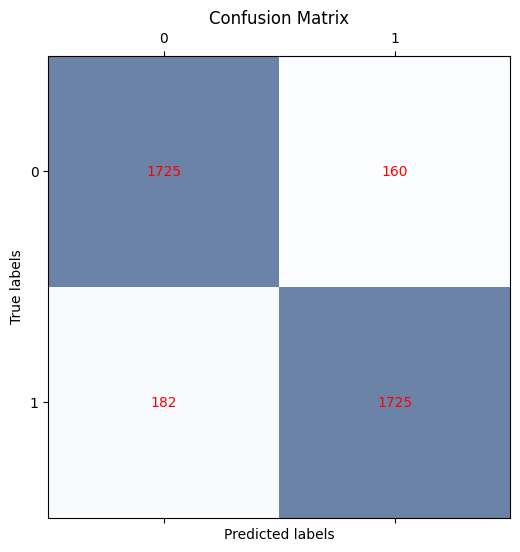

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

def svm_with_smote_sentiment_analysis_balanced(df):
    """Balanced veri seti ile SVM ve SMOTE kullanarak duygu analizi yapar."""

    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # TF-IDF vektörleştirme
    X_train_tfidf, X_test_tfidf, _ = vectorize_text(X_train, X_test)

    # SMOTE ile veri dengeleme
    X_train_resampled, y_train_resampled = apply_smote(X_train_tfidf, y_train)

    # SVM modeli oluştur ve değerlendir
    model = SVC(kernel='linear', class_weight='balanced', random_state=42)
    accuracy, report, cm = train_and_evaluate_model(
        model, X_train_resampled, y_train_resampled, X_test_tfidf, y_test
    )

    return accuracy, report, cm

# SVM analizi
accuracy, report, cm = svm_with_smote_sentiment_analysis_balanced(balanced_data)

# Sonuçları yazdır
print("SVM with SMOTE Accuracy (Balanced Data):", accuracy)
print("SVM with SMOTE Classification Report (Balanced Data):\n", report)
print("SVM with SMOTE Confusion Matrix (Balanced Data):\n", cm)

plot_confusion_matrix(cm)

Naive Bayes with SMOTE Accuracy: 0.9042721518987342
Naive Bayes with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1885
           1       0.89      0.93      0.91      1907

    accuracy                           0.90      3792
   macro avg       0.91      0.90      0.90      3792
weighted avg       0.91      0.90      0.90      3792

Naive Bayes with SMOTE Confusion Matrix:
 [[1662  223]
 [ 140 1767]]


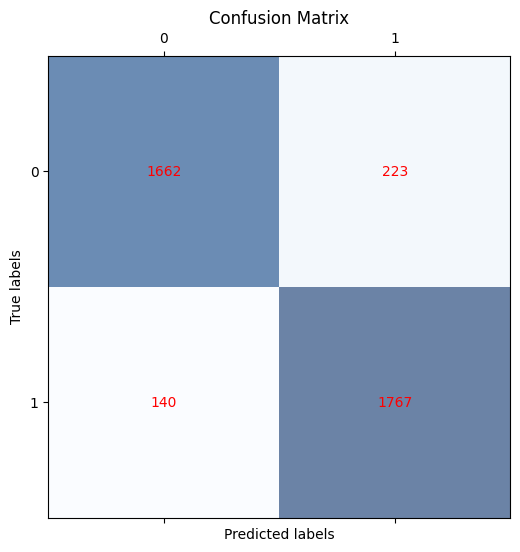

In [9]:
from sklearn.naive_bayes import MultinomialNB

def naive_bayes_with_smote_sentiment_analysis(df):
    """Naive Bayes ve SMOTE kullanarak duygu analizi yapar."""

    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # TF-IDF vektörleştirme
    X_train_tfidf, X_test_tfidf, _ = vectorize_text(X_train, X_test)

    # SMOTE ile veri dengeleme
    X_train_resampled, y_train_resampled = apply_smote(X_train_tfidf, y_train)

    # Naive Bayes modelini oluştur
    model = MultinomialNB()

    # Modeli eğit ve değerlendir
    accuracy, report, cm = train_and_evaluate_model(
        model, X_train_resampled, y_train_resampled, X_test_tfidf, y_test
    )

    return accuracy, report, cm

# Naive Bayes analizi
accuracy, report, cm = naive_bayes_with_smote_sentiment_analysis(balanced_data)

# Sonuçları yazdır
print("Naive Bayes with SMOTE Accuracy:", accuracy)
print("Naive Bayes with SMOTE Classification Report:\n", report)
print("Naive Bayes with SMOTE Confusion Matrix:\n", cm)

plot_confusion_matrix(cm)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_text_with_tokenizer(train_text, test_text, max_length=100):
    """
    Metinleri tokenize eder ve belirli bir uzunlukta padding uygular.
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)

    # Sayısal verilere dönüştürme
    train_seq = tokenizer.texts_to_sequences(train_text)
    test_seq = tokenizer.texts_to_sequences(test_text)

    # Padding işlemi
    train_padded = pad_sequences(train_seq, maxlen=max_length, padding='post')
    test_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')

    return train_padded, test_padded, tokenizer

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

def build_rnn_model(input_dim, max_length, embedding_dim=100):
    """
    RNN (Bidirectional LSTM) modeli oluşturur.
    """
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 135s 478ms/step - accuracy: 0.6823 - loss: 0.7052 - val_accuracy: 0.8819 - val_loss: 0.3125
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 136s 453ms/step - accuracy: 0.9383 - loss: 0.2395 - val_accuracy: 0.9003 - val_loss: 0.2663
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 162s 537ms/step - accuracy: 0.9722 - loss: 0.1296 - val_accuracy: 0.8871 - val_loss: 0.4218
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 131s 492ms/step - accuracy: 0.9807 - loss: 0.0894 - val_accuracy: 0.8795 - val_loss: 0.4076
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 133s 453ms/step - accuracy: 0.9874 - loss: 0.0506 - val_accuracy: 0.8824 - val_loss: 0.4453
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 147s 477ms/step - accuracy: 0.9954 - loss: 0.0231 - val_accuracy: 0.8845 - val_loss: 0.5003
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 144s 485ms/step - accuracy: 0.9923 - loss: 0.0305 - val_accuracy: 0.8832 - val_loss: 0.5633
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 136s 460ms/step - accuracy: 0.9950 -

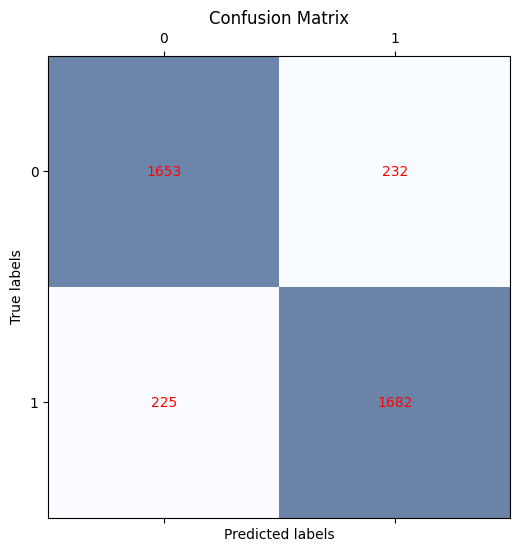

In [12]:
def rnn_with_balancing_smote(df):
    """RNN (Bidirectional LSTM) ve SMOTE kullanarak duygu analizi yapar."""

    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # Metin ön işleme (tokenize ve padding)
    max_length = 100
    X_train_padded, X_test_padded, tokenizer = preprocess_text_with_tokenizer(X_train, X_test, max_length)

    # SMOTE ile veri dengeleme
    X_train_resampled, y_train_resampled = apply_smote(X_train_padded, y_train)

    # Model oluşturma
    input_dim = len(tokenizer.word_index) + 1  # Tokenizer'daki toplam kelime sayısı
    model = build_rnn_model(input_dim, max_length)

    # Modeli eğitme
    model.fit(
        X_train_resampled,
        y_train_resampled,
        epochs=10,
        batch_size=64,
        validation_data=(X_test_padded, y_test),
        class_weight={0: 2, 1: 1}  # Sınıf ağırlıkları
    )

    # Tahmin yap
    y_pred = (model.predict(X_test_padded) > 0.5).astype("int32").flatten()

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, report, cm

# Balanced data ile RNN analizi
accuracy, report, cm = rnn_with_balancing_smote(balanced_data)

# Sonuçları yazdır
print("SMOTE ile dengelenmiş RNN Accuracy:", accuracy)
print("SMOTE ile dengelenmiş RNN Classification Report:\n", report)
print("SMOTE ile dengelenmiş RNN Confusion Matrix:\n", cm)

plot_confusion_matrix(cm)

Lexicon-Based SMOTE Accuracy: 0.6540075535039865
Lexicon-Based SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.82      0.70      9532
           1       0.73      0.48      0.58      9532

    accuracy                           0.65     19064
   macro avg       0.67      0.65      0.64     19064
weighted avg       0.67      0.65      0.64     19064

Lexicon-Based SMOTE Confusion Matrix:
 [[7862 1670]
 [4926 4606]]


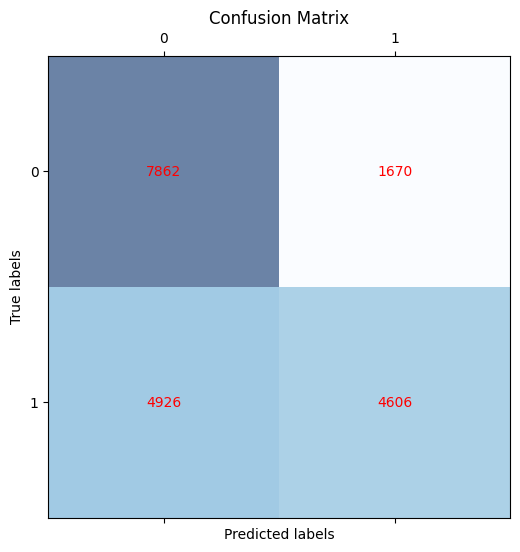

In [13]:

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Pozitif ve negatif kelimelerin listesi
positive_words = ['good', 'great', 'excellent', 'awesome', 'nice']
negative_words = ['bad', 'terrible', 'poor', 'worst', 'awful']

def lexicon_based_sentiment_analysis_with_smote_balanced(df):
    """Lexicon-based sentiment analizi SMOTE ile ve balanced_data kullanarak."""

    # Her yorumdaki kelimeleri analiz ederek duygu puanı döndür
    def get_sentiment(text):
        words = text.split()
        score = 0
        for word in words:
            if word in positive_words:
                score += 1
            elif word in negative_words:
                score -= 1
        return 1 if score > 0 else 0

    # Duygu etiketlerini tahmin et
    df['Lexicon_Sentiment'] = df['cleaned_review'].apply(get_sentiment)

    # SMOTE uygulama
    X_res, y_res = apply_smote(df['Lexicon_Sentiment'].values.reshape(-1, 1), df['Sentiment'])

    # Tahminleri değerlendirme
    accuracy = accuracy_score(y_res, X_res)
    report = classification_report(y_res, X_res)
    cm = confusion_matrix(y_res, X_res)

    # Sonuçları yazdır
    print("Lexicon-Based SMOTE Accuracy:", accuracy)
    print("Lexicon-Based SMOTE Classification Report:\n", report)
    print("Lexicon-Based SMOTE Confusion Matrix:\n", cm)

    # Confusion matrix'i görselleştir
    plot_confusion_matrix(cm)

    return accuracy, report, cm

# Lexicon-based fonksiyonunu balanced_data ile çağırma
accuracy, report, cm = lexicon_based_sentiment_analysis_with_smote_balanced(balanced_data)

Aspect-Based Sentiment Analysis with SMOTE
Accuracy: 0.6508078052874527
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.83      0.70      9532
           1       0.73      0.47      0.58      9532

    accuracy                           0.65     19064
   macro avg       0.67      0.65      0.64     19064
weighted avg       0.67      0.65      0.64     19064

Confusion Matrix:
 [[7896 1636]
 [5021 4511]]


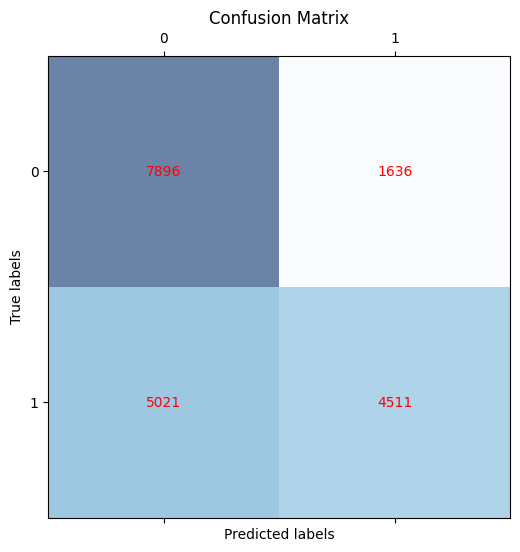

In [14]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

# Aspect kelime listeleri
aspects = {
    'hız': ['fast', 'quick', 'speed', 'late', 'delayed'],
    'kalite': ['good', 'great', 'excellent', 'poor', 'bad', 'terrible', 'quality']
}

def aspect_based_sentiment_analysis_with_smote_balanced(df):
    """Aspect-based sentiment analizi SMOTE ile ve balanced_data kullanarak."""

    # Her özellik için duygu analizi yap
    def get_aspect_sentiment(text):
        words = text.split()
        aspect_scores = {aspect: 0 for aspect in aspects.keys()}
        for word in words:
            for aspect, keywords in aspects.items():
                if word in keywords:
                    aspect_scores[aspect] += 1
        return aspect_scores['hız'], aspect_scores['kalite']

    # Her bir yorum için aspect-based duygu analizi yap
    df[['Aspect_Hız', 'Aspect_Kalite']] = df['cleaned_review'].apply(get_aspect_sentiment).apply(pd.Series)

    # CountVectorizer ile kelime sıklığı (word count) çıkarımı
    vectorizer = CountVectorizer(vocabulary=sum(aspects.values(), []))
    X_aspects = vectorizer.fit_transform(df['cleaned_review']).toarray()

    # SMOTE uygulama (X: özellikler, y: etiketler)
    smote = SMOTE(k_neighbors=3)
    X_res, y_res = apply_smote(X_aspects, df['Sentiment'])

    # Model tanımlama
    model = RandomForestClassifier(random_state=42)

    # Model eğitimi
    model.fit(X_res, y_res)
    y_pred = model.predict(X_res)

    # Sonuçların değerlendirilmesi
    accuracy = accuracy_score(y_res, y_pred)
    report = classification_report(y_res, y_pred)
    cm = confusion_matrix(y_res, y_pred)

    # Sonuçların yazdırılması
    print("Aspect-Based Sentiment Analysis with SMOTE")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    return accuracy, report, cm

# Aspect-based fonksiyonunu çağırma
accuracy, report, cm = aspect_based_sentiment_analysis_with_smote_balanced(balanced_data)
plot_confusion_matrix(cm)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8172 - loss: 0.4718 - val_accuracy: 0.9032 - val_loss: 0.2370
Epoch 2/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9629 - loss: 0.1099 - val_accuracy: 0.9001 - val_loss: 0.2663
Epoch 3/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9888 - loss: 0.0471 - val_accuracy: 0.8985 - val_loss: 0.3333
Epoch 4/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9939 - loss: 0.0233 - val_accuracy: 0.8977 - val_loss: 0.4125
Epoch 5/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9981 - loss: 0.0086 - val_accuracy: 0.8948 - val_loss: 0.4881
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
CNN with SMOTE Accuracy (Balanced Data): 0.8947784810126582
CNN with SMOTE Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      1885
           1       0.90      0.89      0.90      1907

    accuracy                           

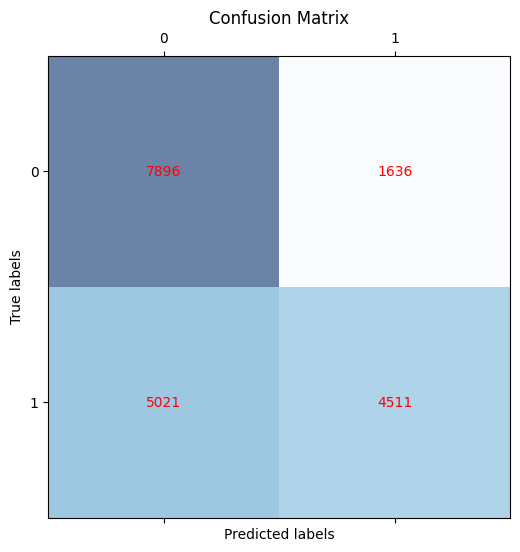

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def cnn_with_smote_sentiment_analysis_balanced(df):
    """Balanced veri seti ile CNN ve SMOTE kullanarak duygu analizi yapar ve sonuçları döner."""
    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # TF-IDF vektörleştirme
    X_train_tfidf, X_test_tfidf, _ = vectorize_text(X_train, X_test)

    # SMOTE ile veri artırımı
    X_train_resampled, y_train_resampled = apply_smote(X_train_tfidf, y_train)

    # CNN Modelini oluştur
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary sınıflandırma için sigmoid
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Modeli eğit
    model.fit(
        X_train_resampled, y_train_resampled,
        epochs=5,
        batch_size=64,
        validation_data=(X_test_tfidf, y_test)
    )

    # Test seti üzerinde tahmin yap
    y_pred = model.predict(X_test_tfidf)
    y_pred = (y_pred > 0.5).astype(int).flatten()  # Sigmoid çıktıyı 0 veya 1'e dönüştür

    # Sonuçları yazdır
    print("CNN with SMOTE Accuracy (Balanced Data):", accuracy_score(y_test, y_pred))
    print("CNN with SMOTE Classification Report (Balanced Data):\n", classification_report(y_test, y_pred))
    print("CNN with SMOTE Confusion Matrix (Balanced Data):\n", confusion_matrix(y_test, y_pred))

    return accuracy, report, cm

# CNN analizi SMOTE ile balanced_data kullanılarak
accuracy, report, cm = cnn_with_smote_sentiment_analysis_balanced(balanced_data)

# Confusion Matrix'i görselleştir
plot_confusion_matrix(cm)

In [16]:
from gensim.models import Word2Vec
import numpy as np

def train_word2vec(corpus):
    """
    Word2Vec modelini eğitir ve kelimeler için vektörleri döndürür.
    """
    tokenized_corpus = [text.split() for text in corpus]  # Her yorumu tokenize et
    model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)
    return model

def vectorize_text_with_word2vec(texts, model):
    """
    Word2Vec ile metni vektörize eder.
    """
    def average_word_vectors(words, model, vector_size):
        # Her kelimenin vektör ortalamasını al
        feature_vec = np.zeros((vector_size,), dtype='float32')
        n_words = 0
        for word in words:
            if word in model.wv:
                feature_vec = np.add(feature_vec, model.wv[word])
                n_words += 1
        if n_words > 0:
            feature_vec = np.divide(feature_vec, n_words)
        return feature_vec

    vector_size = model.vector_size
    return np.array([average_word_vectors(text.split(), model, vector_size) for text in texts])

Word2Vec Sentiment Analysis Accuracy: 0.8051160337552743
Word2Vec Sentiment Analysis Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1885
           1       0.81      0.79      0.80      1907

    accuracy                           0.81      3792
   macro avg       0.81      0.81      0.81      3792
weighted avg       0.81      0.81      0.81      3792

Word2Vec Sentiment Analysis Confusion Matrix:
 [[1539  346]
 [ 393 1514]]


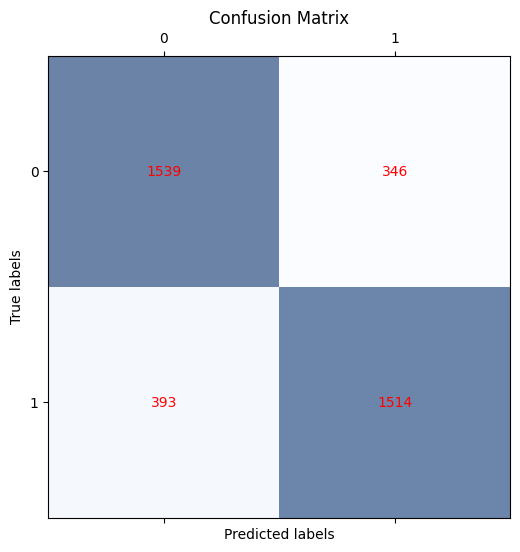

In [17]:
from sklearn.linear_model import LogisticRegression

def word2vec_sentiment_analysis(df):
    """
    Word2Vec ve bir makine öğrenimi modeli ile duygu analizi yapar.
    """
    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # Word2Vec modelini eğit
    word2vec_model = train_word2vec(X_train)

    # Word2Vec ile veriyi vektörize et
    X_train_vec = vectorize_text_with_word2vec(X_train, word2vec_model)
    X_test_vec = vectorize_text_with_word2vec(X_test, word2vec_model)

    # SMOTE uygula
    X_train_resampled, y_train_resampled = apply_smote(X_train_vec, y_train)

    # Model oluştur ve değerlendir
    model = LogisticRegression(random_state=42)
    accuracy, report, cm = train_and_evaluate_model(model, X_train_resampled, y_train_resampled, X_test_vec, y_test)

    return accuracy, report, cm

# Word2Vec ile duygu analizi fonksiyonunu çalıştır
accuracy_word2vec, report_word2vec, cm_word2vec = word2vec_sentiment_analysis(balanced_data)

# Sonuçları yazdır
print("Word2Vec Sentiment Analysis Accuracy:", accuracy_word2vec)
print("Word2Vec Sentiment Analysis Classification Report:\n", report_word2vec)
print("Word2Vec Sentiment Analysis Confusion Matrix:\n", cm_word2vec)

# Confusion Matrix görselleştirmesi
plot_confusion_matrix(cm_word2vec)

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_bert_data(texts, labels, tokenizer, max_len=96):
    """BERT için veri hazırlığı: metinleri ve etiketleri tokenlara dönüştürür."""
    input_ids = []
    attention_masks = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

def bert_sentiment_analysis(df, batch_size=32, max_len=96, epochs=1, gradient_accumulation_steps=4):
    """DistilBERT tabanlı sentiment analizi yapar."""
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')  # Küçük model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    X = df['cleaned_review'].values
    y = df['Sentiment'].values

    input_ids, attention_masks, labels = prepare_bert_data(X, y, tokenizer, max_len)

    train_size = int(0.8 * len(X))
    train_inputs, test_inputs = input_ids[:train_size], input_ids[train_size:]
    train_masks, test_masks = attention_masks[:train_size], attention_masks[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    test_data = TensorDataset(test_inputs, test_masks, test_labels)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    class_weights = torch.tensor([1.0, 5.0]).to(device)  # Pozitif sınıf için ağırlık
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)  # Daha düşük öğrenme oranı

    for epoch in range(epochs):
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            input_ids, attention_masks, labels = [item.to(device) for item in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_masks)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()
            loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader)}")

    model.eval()
    all_preds = []
    all_labels = []

    for batch in test_dataloader:
        input_ids, attention_masks, labels = [item.to(device) for item in batch]
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print("BERT Sentiment Accuracy:", accuracy)
    print("BERT Sentiment Classification Report:\n", report)
    print("BERT Sentiment Confusion Matrix:\n", cm)

    return accuracy, report, cm

# balanced_data DataFrame'inin önceden tanımlı olduğundan emin olun.
accuracy_bert, report_bert, cm_bert = bert_sentiment_analysis(balanced_data)
plot_confusion_matrix(cm_bert)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
